### Imports

In [5]:
from model import Unet
from pnp import pnp_admm
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
import gdown

import torch
import torch.nn.functional as F

import PIL.Image as Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Download plug-in denoiser

In [6]:
url = 'https://drive.google.com/file/d/1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ/view?usp=sharing'
output = "denoiser.pth"
gdown.download(url, output, quiet=False,fuzzy=True)

model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
print('#Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Downloading...
From: https://drive.google.com/uc?id=1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ
To: /Users/luke/Desktop/Galaxy-Deconvolution/plug_and_play_admm/denoiser.pth
100%|██████████| 124M/124M [01:01<00:00, 2.01MB/s]]


#Parameters: 31025027


### Plug and play examples

#### Load test image

In [7]:
# Get sample
test_image = Image.open('figs/test_image.png').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
# test_image = dataset[1231]['target'] # from dataset
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)

#### Motion deblur

PSNR [dB]: 34.79


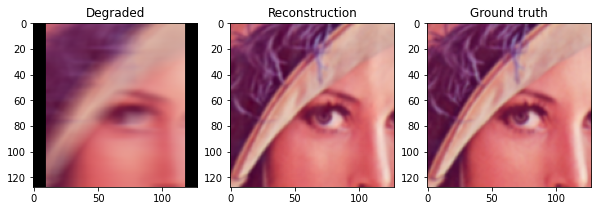

In [8]:
# Motion deblur
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(F.pad(y, (kernel_size//2, kernel_size//2)), x, test_image)

#### Inpainting

PSNR [dB]: 37.04


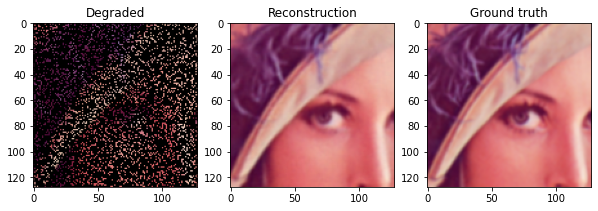

In [9]:
# Inpainting
mask = torch.rand(1,1,h,w).to(device)
mask = mask < 0.2

def forward(x):
    return x*mask
forward_adjoint = forward

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model, num_iter=100)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(y, x, test_image)

#### Super-resolution

PSNR [dB]: 32.50


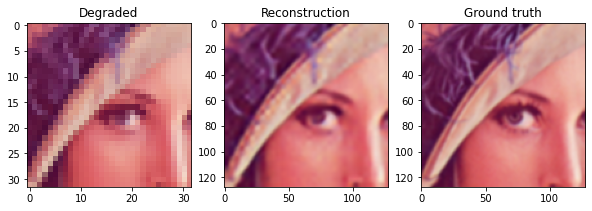

In [10]:
# Super-resolultion
kernel_size = 4
kernel_downsampling = torch.ones((kernel_size, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_downsampling, channels, device, stride=kernel_size)

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model, num_iter=100, max_cgiter=30, cg_tol=1e-4)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(y, x, test_image)